In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')


In [4]:
org_ratings = pd.read_csv('data/ratings.csv')

org_tags = pd.read_csv('data/tags.csv')
org_book_tags = pd.read_csv('data/book_tags.csv')

org_books = pd.read_csv('data/books.csv')
books_enriched = pd.read_csv('data/books_enriched.csv')


#### - ratings will be cleaned to include only users with a certain number of ratings.
#### - book will be merged with books_enriched to add description, language and genres column
#### - the new books dataset will be then merged with a cleaned tags dataset for each book

In [5]:
plt.style.use('ggplot')
sns.set_theme(style = "whitegrid", palette = "viridis")

## Ratings

Contains nearly 6 million records of user ratings. Each entry includes a user ID, a book ID, and the rating given by the user.

In [6]:
ratings = org_ratings

In [7]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [8]:
ratings.shape

(5976479, 3)

#### Plotting User Review Counts

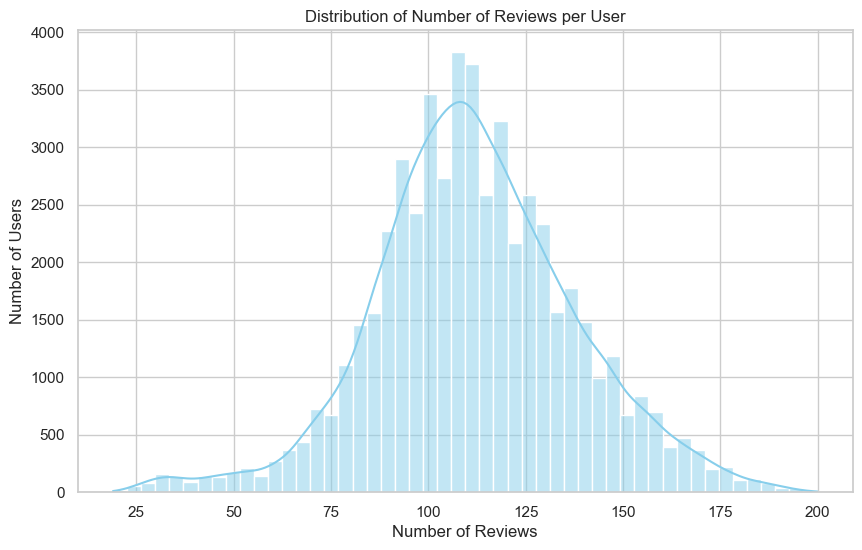

In [9]:
user_reviews_count = ratings.groupby("user_id").size().reset_index(name="num_reviews")

plt.figure(figsize=(10, 6))
sns.histplot(user_reviews_count['num_reviews'], bins=50, kde=True, color='skyblue')

plt.title("Distribution of Number of Reviews per User")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()


## Users

So we need to reduce ratings (users) because 6M will lead to extremely sparse amtrix and computational problems.

### Filtering to Active Users ( ≥ 50 Ratings)
We only keep users who have rated a certain number of books 

Text(0.5, 1.0, 'User Distribution by Rating')

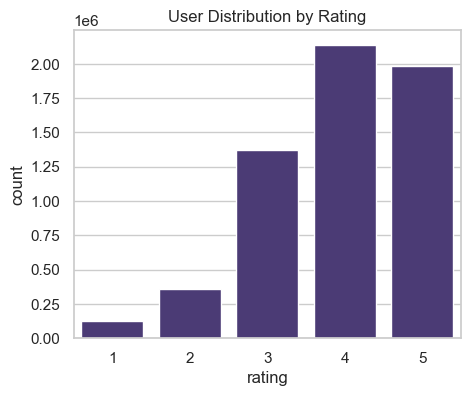

In [10]:
plt.figure(figsize=(5, 4))
sns.countplot(x = "rating", data = ratings)

plt.title('User Distribution by Rating')

most of our users have given positive reviews - most likely because the dataset consists of the top 10k most popular books. 

In [11]:
user_counts = ratings['user_id'].value_counts()

active_users = user_counts[user_counts >= 50].index        # only keep users with more than 50 reviews

ratings = ratings[ratings['user_id'].isin(active_users)]

In [12]:
ratings.shape

(5942836, 3)

In [13]:
unique_user_ids = ratings['user_id'].unique()
print("Total unique users:", len(unique_user_ids))

np.random.seed(42)

Total unique users: 52525


### Since the number of ratings is too large, we will randomly sample a fraction (20%) of active users

In [14]:
# Set the sampling fraction (20%)
sample_fraction = 0.20

sampled_user_ids = np.random.choice(unique_user_ids, size = int(len(unique_user_ids) * sample_fraction), replace = False)
print("Sampled user count:", len(sampled_user_ids))

Sampled user count: 10505


In [15]:
# Filter the ratings to keep every rating associated with the randomly chosen users
ratings = ratings[ratings['user_id'].isin(sampled_user_ids)]
print("Sampled ratings shape:", ratings.shape)

sampled_book_ids = ratings['book_id'].unique()
print("Total unique books in sampled ratings:", len(sampled_book_ids))

Sampled ratings shape: (1185991, 3)
Total unique books in sampled ratings: 9999


In [16]:
ratings.shape

(1185991, 3)

In [17]:
ratings.to_csv('data/FINAL-RATINGS.csv', index = False)

In [89]:
# Set the sampling fraction (50%)
sample_fraction = 0.50

sampled_user_ids = np.random.choice(unique_user_ids, size = int(len(unique_user_ids) * sample_fraction), replace = False)
print("Sampled user count:", len(sampled_user_ids))
# Filter the ratings to keep every rating associated with the randomly chosen users
ratings = ratings[ratings['user_id'].isin(sampled_user_ids)]
print("Sampled ratings shape:", ratings.shape)

sampled_book_ids = ratings['book_id'].unique()
print("Total unique books in sampled ratings:", len(sampled_book_ids))
ratings.shape
ratings.to_csv('data/FINAL-RATINGS-50.csv', index = False)

Sampled user count: 26262
Sampled ratings shape: (587785, 3)
Total unique books in sampled ratings: 9997


## Tags
Maps tag IDs to tag names. 


In [18]:
tags = org_tags

In [19]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


## Book Tags

Establishes a many-to-many relationship between books and tags. Nearly 1 million entries with various tagging combinations across 10k books.


In [20]:
book_tags = org_book_tags

In [21]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [22]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


#### So we have 10,000 books and their corresponding tags and ratings from nearly 6M users.

## Book tags and tags

### Merging Tags with Book_tags

##### Since tag_id is a common column between 'book_tags.csv' datsaset and 'tags.csv', we can merge the two dataset based on the tag_ids


In [23]:
book_tags = book_tags.drop_duplicates() # to remove repeated book–tag links

In [24]:
tags = book_tags.merge(tags, on = 'tag_id') # merge on tag_id to bring in tag_name.

In [25]:
tags.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [26]:
# merge on goodreads_book_id to bring in book titles
books = org_books
new_tags = tags.merge(books[['goodreads_book_id', 'title']], on = 'goodreads_book_id')

In [27]:
new_tags.head()

,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...


In [31]:
new_tags.head()

,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...


In [32]:
tags = new_tags

In [33]:
tags.shape

(999906, 5)

In [34]:
tags_copy = tags.copy()

In [35]:
tag_usage = tags.groupby("tag_name")["count"].sum()

stats = tag_usage.describe().apply(lambda x: f"{x:,.2f}")
print(stats)


count         34,252.00
mean           6,097.49
std          762,709.17
min               -1.00
25%                3.00
50%               10.00
75%               52.00
max      140,718,761.00
Name: count, dtype: object


In [36]:
# remove entries with a count of -1
filtered_usage = tag_usage[tag_usage != -1]

In [37]:
tag_counts = tags.groupby('tag_name')['goodreads_book_id'].nunique()
popular_tags = tag_counts[tag_counts >= 300].index
tags = tags[tags['tag_name'].isin(popular_tags)]

# only keep tags used for atleast 300 books

In [38]:
tags.shape

(710695, 5)

#### Let's take a look at the most Popular and Rare Tags

In [39]:
tag_counts = tags.groupby('tag_name').tag_name.count().sort_values(ascending = False)
tag_counts.head(10)

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
Name: tag_name, dtype: int64

#### Least popular tags (usage > 300)

In [40]:
tag_counts = tags.groupby('tag_name').tag_name.count().sort_values(ascending = True)
tag_counts.head(10)

tag_name
futuristic         300
hot                300
guilty-pleasure    303
faith              305
read-as-a-child    305
werewolves         306
1001-to-read       307
partially-read     308
award-winners      308
space              308
Name: tag_name, dtype: int64

##### there's a lot of repetition of similar tags. Let's try to cluster similar tags together using k-means and tf-idf.

#### Agenda: 
- Distill the number of tags 

- concat cleaned tags under one column

##### Steps:
 - remove less used tags - done by only keeping tags used for atleast 300 books

 - try to cluster similar tags using porter stemmer (did not work)

    - Alt: using TF-iDF and k-means clustering to create groups of tags then using those to create groups of tags

In [41]:
# list of all distinct tag strings
unique_tags = tags['tag_name'].dropna().unique()
unique_tags_sorted = sorted(unique_tags)

print("List of all unique tags:")
print(unique_tags_sorted)

List of all unique tags:
['1', '1001', '1001-books', '1001-books-to-read', '1001-books-to-read-before-you-die', '1001-books-you-must-read-before-you', '1001-import', '1001-to-read', '1990s', '19th-century', '2000s', '2005', '2006', '2011-reads', '2012-reads', '2013-books', '2013-read', '2013-reads', '2014-books', '2014-read', '2014-reads', '2015-books', '2015-read', '2015-reading-challenge', '2015-reads', '2016-books', '2016-read', '2016-reading-challenge', '2016-reads', '2017-books', '2017-reading-challenge', '2017-reads', '20th-century', '21st-century', '3-stars', '4-stars', '5-star', '5-stars', 'abandoned', 'abuse', 'action', 'action-adventure', 'adult', 'adult-fiction', 'adult-non-fiction', 'adult-nonfiction', 'adult-romance', 'adventure', 'all-time-favorites', 'alpha-male', 'already-read', 'america', 'american', 'american-history', 'american-lit', 'american-literature', 'animals', 'arc', 'art', 'asia', 'audible', 'audio', 'audio-book', 'audio-books', 'audiobook', 'audiobooks', 'au

In [42]:
unique_tags_sorted = [str(tag) for tag in unique_tags_sorted if tag is not None]

In [43]:
len(unique_tags_sorted) # number of tags

502

## Creating clusters using K-means

In [44]:
# TfidfVectorizer converts each tag into a TF–IDF feature vector (including unigrams and bigrams)

vectorizer = TfidfVectorizer(ngram_range = (1,2))

X = vectorizer.fit_transform(unique_tags)

#### let's cluster the TF–IDF vectors into 60 groups, so we can see which tags are semantically similar.

In [45]:
# clustering on the TF-IDF vectors
n_clusters = 70 
kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
kmeans.fit(X)
labels = kmeans.labels_

In [46]:
# reducing the TF-IDF vectors to 2 dimensions using t-SNE
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30, n_iter = 1000)
X_tsne = tsne.fit_transform(X.toarray())

In [47]:
# Group tags by their assigned cluster label
clusters = {}
for tag, label in zip(unique_tags, kmeans.labels_):
    clusters.setdefault(label, []).append(tag)

# Concatenate the tags within each cluster 
for cluster_label, tag_list in clusters.items():
    combined_tags = " ".join(tag_list)
    print(f"Cluster {cluster_label}:\n{combined_tags}\n ")

Cluster 48:
to-read to-read-fiction to-read-non-fiction non-fiction-to-read own-to-read owned-to-read want-to-read fiction-to-read to-read-owned to-read-own 1001-to-read to-read-fantasy
 
Cluster 39:
fantasy favorites currently-reading fiction books-i-own favourites magic adventure all-time-favorites default my-books audiobook kids middle-grade audiobooks paranormal read-more-than-once english urban-fantasy read-in-2016 supernatural my-favorites novel 2005 scifi-fantasy faves read-in-2015 made-me-cry juvenile shelfari-favorites kindle youth favourite read-in-2014 kids-books ebook read-in-english 5-star coming-of-age read-in-2017 england favs fantasy-scifi have action movie read-in-2013 fantasy-fiction read-in-2011 juvenile-fiction finished borrowed female-author books-i-have mine read-2016 friendship read-2015 werewolves loved love not-interested other humor epic-fantasy wish-list recommended funny high-fantasy shelfari-wishlist youngadult part-of-a-series action-adventure loved-it sci

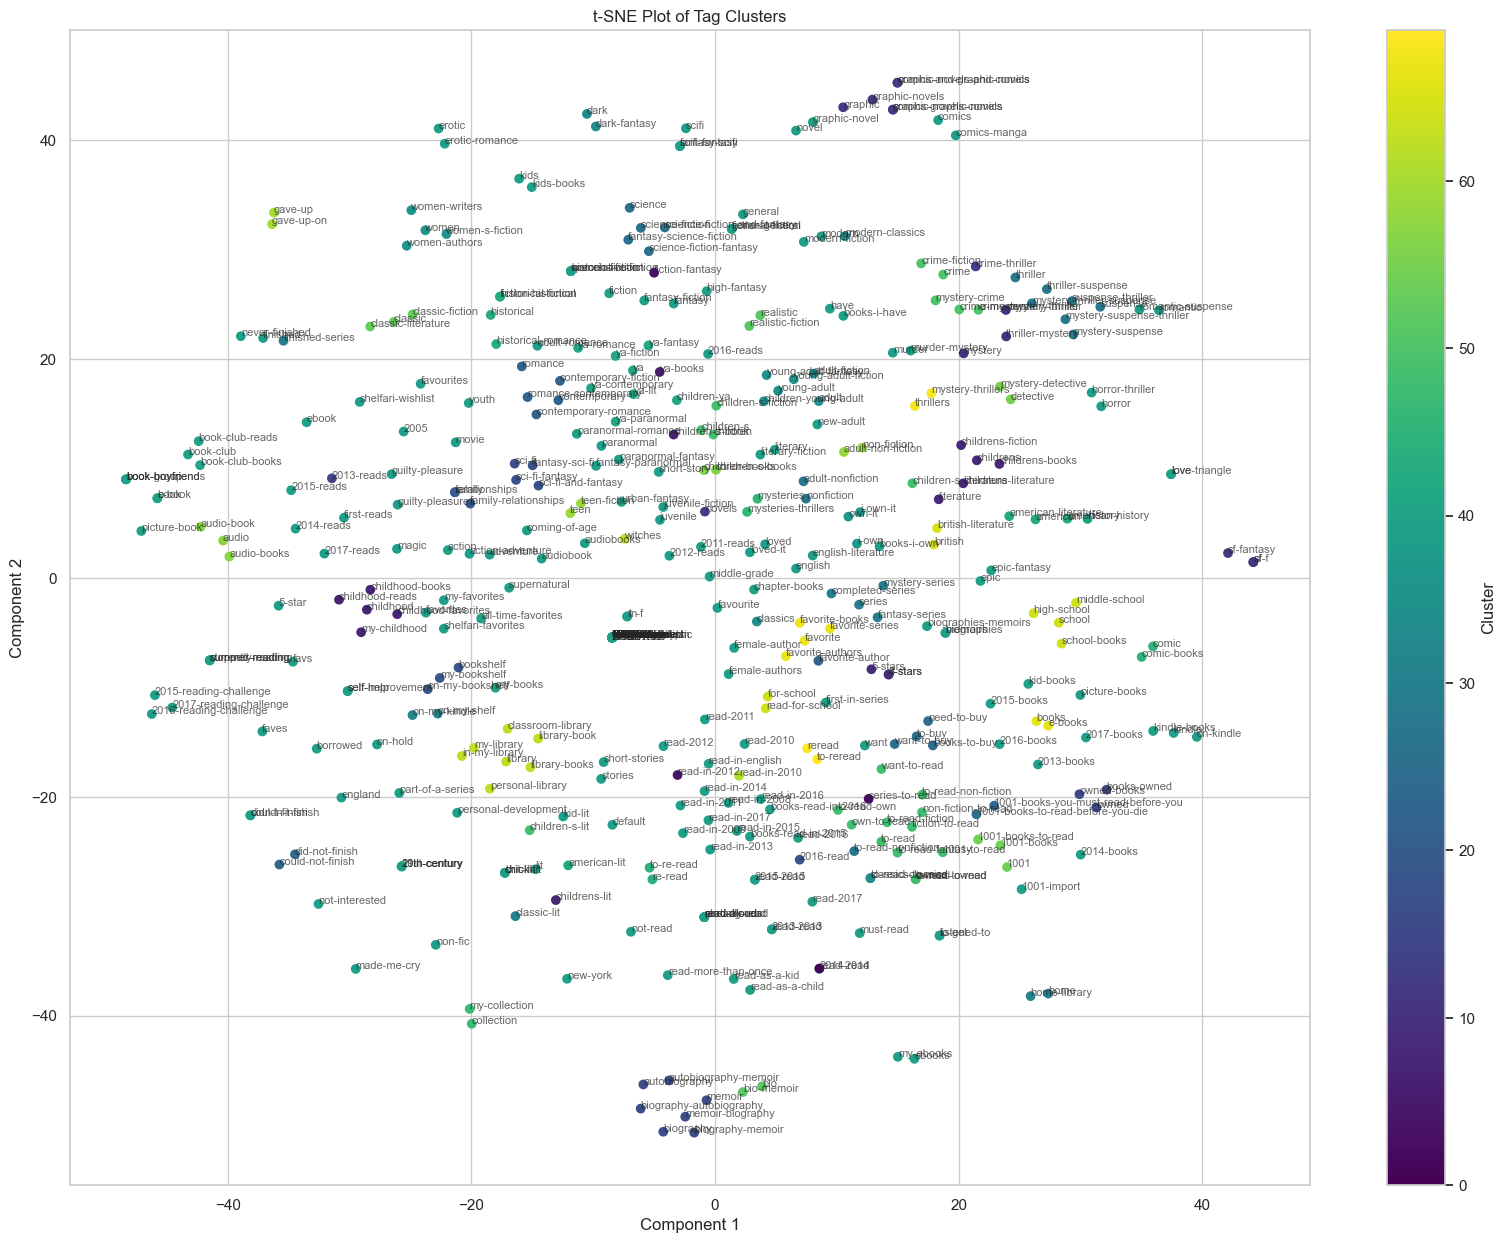

In [48]:
plt.figure(figsize = (20, 15))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = labels, cmap = 'viridis')

for i, tag in enumerate(unique_tags):
    plt.annotate(tag, (X_tsne[i, 0], X_tsne[i, 1]), fontsize = 8, alpha = 0.7)

plt.title('t-SNE Plot of Tag Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(scatter, label = 'Cluster')
plt.show()

## Mapping old tags to a single new tag (creating genres)

In [49]:
tagsdf = tags.copy()

#### new mapping accoridng to existing tag names (which also include genres)

genres = "art", "biography", "business", "chick-lit", "children's", "christian", "classics",
          "comics", "contemporary", "cookbooks", "crime", "books", "fantasy", "fiction",
          "gay-and-lesbian", "graphic-novels", "historical-fiction", "history", "horror",
          "humor-and-comedy", "manga", "memoir", "music", "mystery", "nonfiction", "paranormal",
          "philosophy", "poetry", "psychology", "religion", "romance", "science", "science-fiction", 
          "self-help", "suspense", "spirituality", "sports", "thriller", "travel", "young-adult"


In [116]:
mapping = {
    "art": ["art"],
    "biography": [
        "biography", "biographies", "biographical",
        "autobiography", "autobiography-memoir",
        "biography-autobiography", "biography-memoir",
        "biographies-memoirs", "bio", "bio-memoir"
    ],
    "business": ["business"],
    "chick-lit": ["chick-lit", "chic-lit", "chicklit"],
    "children's": [
        "children", "childrens", "childrens-books", "childrens-lit", "childrens-fiction",
        "childrens-literature", "children-s", "children-s-book", "children-s-books",
        "children-s-lit", "children-s-literature", "childhood",
        "childhood-books", "childhood-favorites", "childhood-reads"
    ],
    "christian": ["christian"],
    "classics": [
        "classic", "classic-fiction", "classic-lit", "classic-literature",
        "classics", "classics-to-read", "modern-classics", "to-read-classics"
    ],
    "comics": [
        "comic", "comic-books", "comics", "comics-and-graphic-novels",
        "comics-graphic-novels"
    ],
    "contemporary": ["contemporary", "contemporary-fiction", "contemporary-romance"],
    "cookbooks": ["cookbooks"],
    "crime": [
        "crime", "crime-fiction", "crime-mystery", "crime-mystery-thriller", "crime-thriller"
    ],
    "books": ["book", "books"],
    "fantasy": [
        "fantasy", "fantasy-fiction", "fantasy-paranormal", "epic-fantasy",
        "high-fantasy", "dark-fantasy", "urban-fantasy", "fantasy-series",
        "fantasy-sci-fi", "fantasy-scifi", "fantasy-science-fiction"
    ],
    "fiction": [
        "fiction", "fiction-general", "fiction-historical", "fiction-to-read"
    ],
    "gay-and-lesbian": ["lgbt"],
    "graphic-novels": [
        "graphic", "graphic-novel", "graphic-novels",
        "graphic-novels-and-comics", "graphic-novels-comics"
    ],
    "historical-fiction": ["historical-fiction", "historic-fiction"],
    "history": ["history", "american-history"],
    "horror": ["horror", "horror-thriller"],
    "humor-and-comedy": ["humor", "humorous", "humour", "comedy"],
    "manga": ["manga", "comics-manga"],
    "memoir": ["memoir", "memoirs"],
    "music": ["music"],
    "mystery": ["mystery", "mysteries", "mystery-crime", "mystery-detective"],
    "nonfiction": ["nonfiction", "non-fiction", "nonfic", "non-fic", "non-fiction-to-read"],
    "paranormal": ["paranormal", "paranormal-fantasy", "paranormal-romance", "supernatural"],
    "philosophy": ["philosophy"],
    "poetry": ["poetry"],
    "psychology": ["psychology"],
    "religion": ["religion"],
    "romance": ["romance", "erotic-romance", "romantic", "romantic-suspense", "steamy"],
    "science": ["science"],
    "science-fiction": [
        "science-fiction", "sci-fi", "scifi",
        "science-fiction-and-fantasy", "science-fiction-fantasy",
        "sci-fi-and-fantasy", "sci-fi-fantasy"
    ],
    "self-help": ["self-help", "self-improvement"],
    "suspense": ["suspense"],
    "spirituality": ["spirituality", "spiritual"],
    "sports": ["sports"],
    "thriller": ["thriller", "thrillers", "thriller-mystery"],
    "travel": ["travel"],
    "young-adult": [
        "young-adult", "ya", "ya-books", "youngadult", "new-adult",
        "teen", "teen-fiction", "children-ya", "ya-fiction",
        "ya-fantasy", "ya-romance", "ya-paranormal"
    ]
}



In [ ]:
"""mapping = {

    # GENRE GROUPS 

    "childrens": [  
        'childrens', 'childrens-books', 'childrens-lit', 'childrens-literature',
        'childrens-fiction', 'children', 'children-s', 'children-s-literature',
        'children-s-lit', 'children-s-fiction', 'childhood', 'childhood-favorites',
        'childhood-books', 'childhood-reads', 'my-childhood', 'children-s-book', 'kids', 
        'children-s-books', 'middle-grade', 'read-as-a-child', 'read-as-a-kid','childrens'
    ],
    "classics": [   
        'classics', 'modern-classics', 'classics-to-read',
        'to-read-classics', 'classic', 'classic-literature', 'classic-fiction'
    ],
    "fantasy_scifi_group": [  
         'fantasy-scifi', 'fantasy-sci-fi',
        'fantasy-science-fiction',
        'scifi-fantasy', 'sci-fi-fantasy', 'sci-fi-and-fantasy',
        'science-fiction-and-fantasy', 'science-fiction-fantasy'
    ],
    "general_fiction_group": [
        'fiction', 'fiction-general', 'novel', 'novels', 'literary'
    ],
    "graphic-novels": [
        'graphic-novels', 'comics-graphic-novels', 'comics-and-graphic-novels',
        'graphic-novels-comics', 'graphic-novels-and-comics',
        'comic', 'comic-books'
    ],
    "mystery_thriller_group": [
        'crime', 'crime-fiction', 'crime-mystery', 'crime-mystery-thriller',
        'crime-thriller', 'detective', 'mysteries', 'mysteries-thrillers',
        'mystery-crime', 'mystery-detective', 'mystery-suspense',
        'mystery-suspense-thriller', 'mystery-thrillers', 'mystery-thriller-suspense',
        'suspense-thriller', 'thriller-suspense', 'thrillers'
    ],
    "nonfiction": [
        'nonfiction', 'non-fiction', 'to-read-nonfiction',
        'memoir', 'biography', 'biography-memoir', 'memoir-biography',
        'biography-autobiography', 'autobiography', 'autobiography-memoir',
        'bio-memoir', 'bio'
    ],
    "romance": [
        'romance', 'contemporary-romance', 'romance-contemporary',
        'adult-romance', 'erotic-romance', 'erotica', 'romantic-suspense',
        'love-triangle', 'alpha-male', 'm-f', 'steamy', 'hot', 'romance', 'romantic',
    ],
    "young-adult": [ 
        'young-adult', 'young-adult-fiction', 'young-adult-fantasy',
        'children-young-adult', 'teen', 'teen-fiction', 'new-adult', 'ya'
    ],
    
    # NON-GENRE GROUPS 
    
    "book-club": [
        'book-club', 'book-club-books', 'book-club-reads',
        'book-group', 'bookclub'
    ],
    "date_read_group": [
        'read-in-2016', 'read-in-2015', 'read-in-2014', 'read-in-2017',
        'read-in-2013', 'read-in-2011', 'read-in-2008', 'read-in-2009',
        '2016-reads', '2017-reads', '2015-reads', '2013-reads', '1990s', 
        '19th-century', '2000s', '2005', '2006', '2011-reads', '2012-reads', 
        '2013-books', '2013-read', '2014-books', '2014-read', '2014-reads', '2015-books', 
        '2015-read', '2015-reading-challenge', '2016-books', '2016-read', '2016-reading-challenge',
        '2017-books', '2017-reading-challenge', '20th-century',
    ],
    "favorites": [
        'favorites', 'favourites', 'all-time-favorites', 'my-favorites',
        'shelfari-favorites', 'wish-list', 'recommended', 'fave', 'favs', 'favorite-books', '5-stars'
        'faves', 'favorite', 'favorite-author', 'favorite-authors', 'favorite-series', 'favorites', 'favourite'
    ],
    "to-buy": [
        'to-buy', 'want-to-buy', 'need-to-buy', 'books-to-buy'
    ],
    "chick-lit": [  
        'chick-lit', 'chicklit', 'chic-lit'
    ],
    "supernatural_group": [
        'vampire', 'vampires', 'vamps', 'werewolves', 'witches', 'supernatural'
    ],
    "on_shelf_group": [
        'on-my-shelf', 'on-my-kindle', 'my-bookshelf',
        'bookshelf', 'on-my-bookshelf', 'home-library'
    ],
    "books-i-own": [
        'books-i-own', 'books-i-have', 'owned', 'owned-to-read', 'mine',
        'owned-books', 'books-owned', 'i-own', 'own-it', 'i-own-it',
        'collection', 'my-collection'
    ],
    "dnf": [
        'dnf', "didn-t-finish", "couldn-t-finish", 'not-read', 'unread',
        'did-not-finish', 'could-not-finish', 'partially-read'
    ],
    "to_read_1001_group": [
        '1001-books', '1001', '1001-books-to-read',
        '1001-books-to-read-before-you-die', '1001-books-you-must-read-before-you', '1001-import'
    ],
    "to-read": [
        'to-read', 'own-to-read', 'owned-to-read', 'want-to-read',
        'to-read-owned', 'to-read-own', '1001-to-read', 'to-re-read',
        're-read', 'reread', 'to-reread'
    ]
}
"""

In [117]:
# Create a reverse mapping: for every original tag we map it to its normalized group key
rev_map = {orig: new 
           for new, orig_list in mapping.items() 
           for orig in orig_list}

tagsdf['tag_name'] = tagsdf['tag_name'].apply(lambda x: rev_map.get(x, x))
tagsdf.drop_duplicates(subset=['title', 'tag_name'], inplace=True)


In [118]:
tagsdf.head(20)

,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...
5,1,11743,9954,general_fiction_group,Harry Potter and the Half-Blood Prince (Harry ...
7,1,5207,6221,books-i-own,Harry Potter and the Half-Blood Prince (Harry ...
10,1,27199,3857,series,Harry Potter and the Half-Blood Prince (Harry ...
12,1,18886,3374,magic,Harry Potter and the Half-Blood Prince (Harry ...
13,1,6953,2408,children's,Harry Potter and the Half-Blood Prince (Harry ...


In [119]:
tagsdf.shape

(472643, 5)

In [120]:
new_unique_tags = tagsdf['tag_name'].dropna().unique()
new_unique_tags_sorted = sorted(new_unique_tags)

print("List of all unique tags:")
print(new_unique_tags_sorted)

List of all unique tags:
['1', '21st-century', '3-stars', '4-stars', '5-star', '5-stars', 'abandoned', 'abuse', 'action', 'action-adventure', 'adult', 'adult-fiction', 'adult-non-fiction', 'adult-nonfiction', 'adventure', 'already-read', 'america', 'american', 'american-lit', 'american-literature', 'animals', 'arc', 'art', 'asia', 'audible', 'audio', 'audio-book', 'audio-books', 'audiobook', 'audiobooks', 'award-winners', 'biography', 'book-boyfriend', 'book-boyfriends', 'book-club', 'books', 'books-i-own', 'books-read-in-2015', 'books-read-in-2016', 'borrowed', 'bought', 'brit-lit', 'british', 'british-literature', 'business', 'calibre', 'chapter-books', 'chick-lit', "children's", 'children-books', 'christian', 'classics', 'classroom-library', 'college', 'comics', 'coming-of-age', 'completed-series', 'contemporary', 'cultural', 'culture', 'currently-reading', 'dark', 'date_read_group', 'death', 'default', 'demons', 'dnf', 'drama', 'dystopia', 'dystopian', 'e-book', 'e-books', 'ebook',

In [121]:
len(new_unique_tags_sorted)

279

In [122]:
tags = tagsdf

#### So we brought the number of tags from 502 to 317

### Concatenating all the tags (from separate rows) into one space-separated string per book

In [123]:
grouped_tags = tags.groupby(['goodreads_book_id', 'title'])['tag_name'] \
                 .apply(lambda tags: ' '.join(tags)) \
                 .reset_index()

In [124]:
grouped_tags.head(5)

,goodreads_book_id,title,tag_name
0,1,Harry Potter and the Half-Blood Prince (Harry ...,to-read fantasy favorites currently-reading yo...
1,2,Harry Potter and the Order of the Phoenix (Har...,to-read currently-reading fantasy favorites ch...
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,to-read favorites fantasy currently-reading yo...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,favorites fantasy currently-reading young-adul...
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,fantasy young-adult general_fiction_group book...


In [125]:
grouped_tags.shape

(10000, 3)

### Creating new book csv with description and all tags

In [126]:
books = books[['book_id', 'goodreads_book_id', 'title', 'authors', 'average_rating', 'ratings_count']]

In [127]:
books.head()

,book_id,goodreads_book_id,title,authors,average_rating,ratings_count
0,1,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
1,2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479
2,3,41865,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839
3,4,2657,To Kill a Mockingbird,Harper Lee,4.25,3198671
4,5,4671,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664


In [128]:
grouped_tags.head()

,goodreads_book_id,title,tag_name
0,1,Harry Potter and the Half-Blood Prince (Harry ...,to-read fantasy favorites currently-reading yo...
1,2,Harry Potter and the Order of the Phoenix (Har...,to-read currently-reading fantasy favorites ch...
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,to-read favorites fantasy currently-reading yo...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,favorites fantasy currently-reading young-adul...
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,fantasy young-adult general_fiction_group book...


In [129]:
booktags = grouped_tags.copy()

#### we have another dataset books_enriched which also contains the book genres and summary, which will be later used for content-based filtering. 

In [130]:
books_enriched.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 10000 non-null  int64  
 1   index                      10000 non-null  int64  
 2   authors                    10000 non-null  object 
 3   average_rating             10000 non-null  float64
 4   best_book_id               10000 non-null  int64  
 5   book_id                    10000 non-null  int64  
 6   books_count                10000 non-null  int64  
 7   description                9943 non-null   object 
 8   genres                     10000 non-null  object 
 9   goodreads_book_id          10000 non-null  int64  
 10  image_url                  10000 non-null  object 
 11  isbn                       9300 non-null   object 
 12  isbn13                     9415 non-null   float64
 13  language_code              10000 non-null  obje

In [131]:
# selecting the columns from books_enriched that we want to join:
subset = books_enriched[['goodreads_book_id', 'description', 'genres', 'language_code']]
merged_books = pd.merge(books, subset, on='goodreads_book_id', how='left')


In [132]:
merged_books.head()

,book_id,goodreads_book_id,title,authors,average_rating,ratings_count,description,genres,language_code
0,1,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",eng
1,2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",eng
2,3,41865,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",eng
3,4,2657,To Kill a Mockingbird,Harper Lee,4.25,3198671,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",eng
4,5,4671,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664,"The Great Gatsby, F. Scott Fitzgerald's third ...","['classics', 'fiction', 'historical-fiction', ...",eng


### combining Genres & Tags into Final Book Table
##### 1. Parse 'genres' into Python lists
##### 2. Parse and group 'tag_name' from booktags
##### 3. Merge parsed tags into books

In [133]:
def parse_genres(x):
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except:
        return [g.strip() for g in str(x).strip('[]').split(',') if g.strip()]

merged_books['parsed_genres'] = merged_books['genres'].apply(parse_genres)

In [135]:
# Turn each tag_name string into a list of tags
booktags['parsed_tags'] = booktags['tag_name'].fillna('').apply(lambda s: [t for t in s.split() if t])

In [137]:
# Aggregate all tags per book
grouped_tags = (
    booktags
    .groupby('goodreads_book_id')['parsed_tags']
    .apply(lambda lists: sum(lists, []))
    .reset_index()
)

In [138]:
# Merge the tags back into merged_books
final_df = merged_books.merge(grouped_tags, on='goodreads_book_id', how='left')

final_df['parsed_tags'] = final_df['parsed_tags'].apply(
    lambda x: x if isinstance(x, list) else []
)

In [139]:
# Dedupe & sort the union of genres+tags
final_df['unique_tags'] = final_df.apply(
    lambda row: sorted(set(row['parsed_genres']) | set(row['parsed_tags'])),
    axis=1
)

final_df['unique_tags_str'] = final_df['unique_tags'].apply(
    lambda lst: ", ".join(lst)
)

In [140]:
output = final_df[[
    'book_id', 'goodreads_book_id', 'title', 'authors', 'average_rating', 'ratings_count',
    'description', 'unique_tags', 'unique_tags_str'
]]
output.to_csv('data/FINAL-BOOKS-WITH-TAGS.csv', index = False)


In [141]:
output.head()

,book_id,goodreads_book_id,title,authors,average_rating,ratings_count,description,unique_tags,unique_tags_str
0,1,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"[5-star, 5-stars, action, action-adventure, ad...","5-star, 5-stars, action, action-adventure, adv..."
1,2,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479,Harry Potter's life is miserable. His parents ...,"[5-stars, adventure, audio, audiobook, audiobo...","5-stars, adventure, audio, audiobook, audioboo..."
2,3,41865,"Twilight (Twilight, #1)",Stephenie Meyer,3.57,3866839,About three things I was absolutely positive.\...,"[5-stars, abandoned, already-read, american, a...","5-stars, abandoned, already-read, american, au..."
3,4,2657,To Kill a Mockingbird,Harper Lee,4.25,3198671,The unforgettable novel of a childhood in a sl...,"[5-stars, adult, adult-fiction, american, amer...","5-stars, adult, adult-fiction, american, ameri..."
4,5,4671,The Great Gatsby,F. Scott Fitzgerald,3.89,2683664,"The Great Gatsby, F. Scott Fitzgerald's third ...","[5-stars, adult, adult-fiction, america, ameri...","5-stars, adult, adult-fiction, america, americ..."


### Checking to see how much data we've filtered

In [84]:
print(f"Original ratings: {len(org_ratings)}, Filtered ratings: {len(ratings)}, Difference: {len(org_ratings) - len(ratings)}")

Original ratings: 5976479, Filtered ratings: 1185991, Difference: 4790488


In [85]:
print(f"Original books: {len(org_books)}, Filtered books: {len(books)}, Difference: {len(org_books) - len(books)}")

Original books: 10000, Filtered books: 10000, Difference: 0


In [86]:
print(f"Original users: {org_ratings['user_id'].nunique()}, Filtered users: {ratings['user_id'].nunique()}, Difference: {org_ratings['user_id'].nunique() - ratings['user_id'].nunique()}")

Original users: 53424, Filtered users: 10505, Difference: 42919
